# Simple CCZ4 Finite Volume code
 
A solver of the Einstein equations that uses the original ExaHyPE FORTRAN kernels.

In [1]:
import os
import peano4
import exahype2

DaStGen 2 (C) www.peano-framework.org
Peano 4 (C) www.peano-framework.org
ExaHyPE 2 (C) www.peano-framework.org


In [2]:
output_files = [ f for f in os.listdir(".") if f.endswith(".peano-patch-file") or f.endswith(".vtu") or f.startswith("output")]
for f in output_files:
  os.remove(f)

The first thing to do in any ExaHyPE 2 application is to create an ExaHyPE project. We have to tell it exactly what namespace we want to use and we have to give it a name. There are a few more options that we omit here, i.e. we use the defaults.

In [3]:
project = exahype2.Project( ["examples", "exahype2", "ccz4"], "ccz4" )

## Configuring the solver

Our first step is to use a Finite Volumes solver. I write down all the unknowns first. I'll use this dictionary later to access variables symbolically. For the time being, I just define this map and then count the number of unknowns. This total count is something I really need to configure my solver.

In [4]:
unknowns = {
  "G":6,
  "K":6,
  "theta":1,
  "Z":3,
  "lapse":1,
  "shift":3,
  "b":3,
  "dLapse":3,
  "dxShift":3,
  "dyShift":3,
  "dzShift":3,
  "dxG":6,
  "dyG":6,
  "dzG":6,
  "traceK":1,
  "phi":1,
  "P":3,
  "K0":1,
  "rho":1,
  "u":3,
  "p":1
}

number_of_unknowns = 0
for i in unknowns:
  number_of_unknowns += unknowns[i]
print( "number of unknowns=", number_of_unknowns )

number of unknowns= 64


The solver itself is a simple Finite Volume solver with fixed time stepping. I use the enclave solver variant which is a solver nuance that is particuarly good on large shared memory architectures. Our PDE is expressed solely in a nonconservative formulation. I therefore can switch the flux term off.

In [5]:
patch_size          = 6
auxiliary_variables = 0
time_step_size      = 0.01
max_h               = 0.4
min_h               = 0.4

my_solver = exahype2.solvers.fv.GenericRusanovFixedTimeStepSizeWithEnclaves(
  "CCZ4", patch_size, number_of_unknowns, auxiliary_variables, min_h, max_h, time_step_size
)


project.add_solver(my_solver)

I next inject homogeneous Neumann boundary conditions:

In [6]:
import exahype2.sympy

pde = exahype2.sympy.PDE(unknowns=number_of_unknowns,auxiliary_variables=0,dimensions=3)

my_solver.set_implementation(
  boundary_conditions=exahype2.solvers.fv.PDETerms.User_Defined_Implementation,
  flux=exahype2.solvers.fv.PDETerms.None_Implementation,
  ncp=exahype2.solvers.fv.PDETerms.User_Defined_Implementation
)   


## Configure the global domain

We next configure our global domain, i.e. we specify the dimensions of the computational domain $\Omega $, we specify how long the simulation shall run and how often we want it to dump its data. The dumps will later be used to produce screenshots of the data (or to extract all kinds of properties).

In [7]:
#build_mode = peano4.output.CompileMode.Asserts
build_mode = peano4.output.CompileMode.Release

dimensions = 3
end_time = 1
snapshots = time_step_size*1
    
project.set_global_simulation_parameters(
  dimensions,               # dimensions
  [-0.5, -0.5, -0.5],  [1.0, 1.0, 1.0],
  end_time,                 # end time
  0.0, snapshots,   # snapshots
  [True,True,True]          # Periodic BC
)

## Generate a Peano 4 project

This is exactly the same as for Euler: We ask the ExaHyPE 2 front-end to give us a Peano project.

In [8]:
project.set_Peano4_installation("../../..", build_mode)

peano4_project = project.generate_Peano4_project()

parse configure outcome ../../../src/Makefile to extract compile settings
used C++ compiler is icpc
used Fortran compiler is ifort


A "big" difference to Euler is that we now have some external Fortran files. Usually, we take the default settings when we invoke the Fortran compiler. Default is the stuff given to us by Peano's configure. There's however the opportunity to add further flags manually. I use this here as the astro code requies some bespoke defines. Also, I need the -cpp flag. Otherwise the preprocessor macros are not taken into account properly and my Intel compiler terminates.
- The option "-DGLMROT" can be added to enable curl cleaning, however this requires additional variables. Be sure to add these before enabling this option.
- With GNU, I have used 
<pre>
./configure  FC="gfortran" CXX="g++" LDFLAGS="-L/opt/vtk/lib64 -L/opt/intel/tbb/lib/intel64/gcc4.8 -ltbb_debug -lpthread" CXXFLAGS="-I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include"   --enable-exahype --enable-loadbalancing-toolbox --with-multithreading=omp
</pre>
for this one on my system.
- With Intel, I used
<pre>
./configure FC="ifort" CXX="icpc" LDFLAGS="-L/opt/vtk/lib64 -L/opt/intel/tbb/lib/intel64/gcc4.8 -ltbb_debug -lpthread -lifcore" CXXFLAGS="-I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include"   --enable-exahype --enable-loadbalancing-toolbox --with-multithreading=omp
</pre>

In [9]:
peano4_project.output.makefile.add_Fortran_flag( "-DCCZ4EINSTEIN -DDim3" )

# This is for GNU
#peano4_project.output.makefile.add_Fortran_flag( "-lstdc++ -fdefault-real-8 -fdefault-double-8 -cpp -std=legacy -ffree-line-length-512 -fPIC" )
#peano4_project.output.makefile.add_linker_flag( "-lstdc++ -fPIC -lgfortran" )

# This might work for Intel (not tested)
peano4_project.output.makefile.add_Fortran_flag( "-r8 -cpp -auto -qopenmp-simd -O2" )
peano4_project.output.makefile.add_linker_flag( "-lstdc++ -fPIC" )

peano4_project.output.makefile.add_Fortran_module( "MainVariables.f90" )

peano4_project.output.makefile.add_Fortran_files( 
  ["PDE.f90 ", "EinsteinConstraints.f90 ",
    "Metric.f90 ", "C2P-FOCCZ4.f90 "] 
)

# Prepare the CCZ4 solver

This means invoking the right Fortran routines at the right time. First, we have to tell the Fortran lib which scenario we want to work with. For this, we create a symbol identifier in Python and export it into the C++ code.
We then write a standard constructor of the CCZ4 solver which pipes the constant through through the Fortran code. Seems to be quite some overhead, but it allows us to switch the scenario through Python. 

In [10]:
#peano4_project.constants.export_string( "Scenario", "CCZ4GaugeWave")
peano4_project.constants.export_string( "Scenario", "gaugewave-c++" )

# Create C++ code

We finally generate the C++ code:

In [11]:
peano4_project.generate( throw_away_data_after_generation=False )

generate all code ...
some artefacts have already been added to repository ... assume this is intentional (by higher abstraction layer, e.g.)
generated ccz4-main.cpp
write ./Makefile
write ././AbstractCCZ4.h (generated from template /home/tobias/git/Peano/python/exahype2/solvers/fv/GenericRusanovFixedTimeStepSizeWithEnclavesAbstract.template.h)
write ././AbstractCCZ4.cpp (generated from template /home/tobias/git/Peano/python/exahype2/solvers/fv/GenericRusanovFixedTimeStepSizeWithEnclavesAbstract.template.cpp)
write ./observers/SolverRepository.h (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.h)
write ./observers/SolverRepository.cpp (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.cpp)
write ./celldata/CCZ4Q.h (generated from template /home/tobias/git/Peano/python/peano4/datamodel/PatchToDoubleArray.template.h)
write ./celldata/CCZ4Q.cpp (generated from template /home/tobias/git/Peano/pyth

The build below should fail when you first call it in an empty directory. After all, we have promised to deliver an ncp implementation, but there is none.

In [12]:
parallel_builds = 1   # I don't use a massively parallel build here as my laptop otherwise becomes too hot.
                      # Without any arguments, the build process will grab all of your cores.
#peano4_project.build( make_clean_first = False, number_of_parallel_builds = parallel_builds )
!make -j4


icpc -std=c++0x -O2 -DPeanoDebug=0 -I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include -fopenmp  -DDimensions=3 -I. -I../../../src -c -o AbstractCCZ4.o AbstractCCZ4.cpp
icpc -std=c++0x -O2 -DPeanoDebug=0 -I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include -fopenmp  -DDimensions=3 -I. -I../../../src -c -o observers/SolverRepository.o observers/SolverRepository.cpp
icpc -std=c++0x -O2 -DPeanoDebug=0 -I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include -fopenmp  -DDimensions=3 -I. -I../../../src -c -o celldata/CCZ4Q.o celldata/CCZ4Q.cpp
icpc -std=c++0x -O2 -DPeanoDebug=0 -I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include -fopenmp  -DDimensions=3 -I. -I../../../src -c -o celldata/CCZ4CellSemaphoreLabel.o celldata/CCZ4CellSemaphoreLabel.cpp
icpc -std=

icpc -std=c++0x -O2 -DPeanoDebug=0 -I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include -fopenmp  -DDimensions=3 -I. -I../../../src -c -o observers/TimeStep2peano4_toolbox_blockstructured_BackupPatchOverlap4.o observers/TimeStep2peano4_toolbox_blockstructured_BackupPatchOverlap4.cpp
icpc -std=c++0x -O2 -DPeanoDebug=0 -I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include -fopenmp  -DDimensions=3 -I. -I../../../src -c -o observers/TimeStep2exahype2_grid_EnclaveLabels5.o observers/TimeStep2exahype2_grid_EnclaveLabels5.cpp
icpc -std=c++0x -O2 -DPeanoDebug=0 -I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include -fopenmp  -DDimensions=3 -I. -I../../../src -c -o observers/TimeStep2peano4_toolbox_blockstructured_ApplyFunctorOnPatch6.o observers/TimeStep2peano4_toolbox_blockstructured_ApplyFunctorOnPatch6.cpp
icpc -std=

## Run the code and postprocess results

Once we have the Peano 4 project set up and built, we obtain an executable which is standalone. It comprises all the parameters we have set above. So we can either invoke this file on the command line or we can call it through the notebook. Depending on your setup you might want to call the code with a prefix. If you configured Peano with MPI, e.g., you might have to use the mpirun prefix. 

Please note that we pipe the terminal output into a file. This way, we can postprocess the data in the next step.

In [13]:
peano4_project.run( [], prefix = ["mpirun", "-n", "1"], pipefile = "output.txt", rebuild_if_required=False )

run application ...
 18746790172  00:00:18     rank:0       core:5       warning      tarch::logging::Statistics::writeToCSV(string)          no statistics available. Recompile with -DTrackStatistics for runtime sampling (file:tarch/logging/Statistics.cpp,line:142)

run completed without error code, but check for warnings and numerical assertions/errors


True

We first grab and postprocess the data from the output file. This is ExaHyPE 2-specific (though application-generic), so we rely on ExaHyPE's postprocessing routines.



In [14]:
import exahype2.postprocessing

performance_data = exahype2.postprocessing.PerformanceData( "output.txt", verbose=True )

parse output.txt
h_min=0.333333
triggered plot at 0.04217582s
started new time step at 0.092743479s
started new time step at 0.148505081s
triggered plot at 0.15395508s
started new time step at 0.203533758s
started new time step at 0.27747815600000003s
triggered plot at 0.282915459s
started new time step at 0.33628062599999997s
started new time step at 0.417913371s
triggered plot at 0.42351984800000003s
started new time step at 0.47891145400000007s
started new time step at 0.554280572s
triggered plot at 0.559751288s
started new time step at 0.618520265s
started new time step at 0.694397828s
triggered plot at 0.700094003s
started new time step at 0.762171393s
started new time step at 0.8376204749999999s
triggered plot at 0.843230788s
started new time step at 0.910192453s
started new time step at 0.9873121149999999s
triggered plot at 0.9927771639999999s
started new time step at 1.06496877s
started new time step at 1.1407264110000002s
triggered plot at 1.146234238s
started new time step at

In this worksheet, I'd like to have interactive matplotlib plots: You might need the statement

<pre>
%matplotlib widget
</pre>

but on some of my local notebook servers, this causes a crash. So you have to test this yourself.

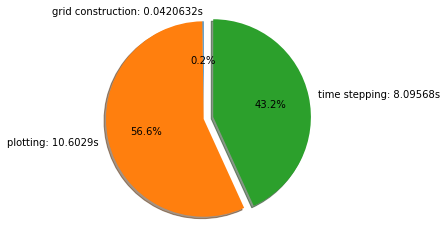

In [15]:
exahype2.postprocessing.plot_pie_chart_over_simulation_phases(performance_data)

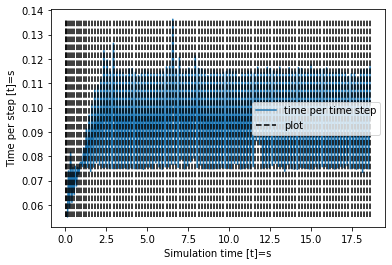

In [16]:
exahype2.postprocessing.plot_time_per_time_step(performance_data)

## Inspecting output files via Paraview

We first do an ls on our directory and search for the root .peano-patch-file. I then convert this file manually into vtu which I can load into Paraview. This works if Peano is configured with vtk support. If you don't have vtk support in there, then you might want to load the data directly into Paraview through Peano's Paraview plug-in.

In [17]:
!ls

AbstractCCZ4.cpp
AbstractCCZ4.h
AbstractCCZ4.o
C2P-FOCCZ4.f90
C2P-FOCCZ4.o
ccz4.avi
CCZ4.cpp
CCZ4.h
CCZ4.ipynb
ccz4-main.cpp
ccz4-main.h
ccz4-main.o
CCZ4.o
celldata
Constants.h
EinsteinConstraints.f90
EinsteinConstraints.o
exahype.log-filter
facedata
MainVariables.f90
mainvariables.mod
MainVariables.o
Makefile
Metric.f90
Metric.o
observers
output.txt
PDE.f90
PDE.h
PDE.o
peano4
snapshot-8.png
solution-CCZ4.peano-patch-file
solution-CCZ4.pvd
solution-CCZ4-tree-0-0.peano-patch-file
solution-CCZ4-tree-0-100.peano-patch-file
solution-CCZ4-tree-0-10.peano-patch-file
solution-CCZ4-tree-0-11.peano-patch-file
solution-CCZ4-tree-0-12.peano-patch-file
solution-CCZ4-tree-0-13.peano-patch-file
solution-CCZ4-tree-0-14.peano-patch-file
solution-CCZ4-tree-0-15.peano-patch-file
solution-CCZ4-tree-0-16.peano-patch-file
solution-CCZ4-tree-0-17.peano-patch-file
solution-CCZ4-tree-0-18.peano-patch-file
solution-CCZ4-tree-0-19.peano-patch-file
solution-CCZ4-tree-0-1.peano-patch-file
solution-CCZ4-tree-0-20.

# Visualisation

We have different ways how to visualise the outcome. If you have VTK support in your configure call, then Peano has built a vtk command line converter. You can just type in:


In [18]:
import peano4.visualisation
convert = peano4.visualisation.Convert( "solution-CCZ4", True )
convert.set_visualisation_tools_path( "../../../src/visualisation" )
convert.extract_fine_grid()
convert.convert_to_vtk()

Error: Cannot import vtkPVServerManagerDefault
Error: Cannot import vtkPVServerManagerRendering
inspect file solution-CCZ4 ... 
invoke ['../../../src/visualisation/convert', 'inspect', 'solution-CCZ4.peano-patch-file']
failed to inspect ([Errno 2] No such file or directory: '../../../src/visualisation/convert') with ['../../../src/visualisation/convert', 'inspect', 'solution-CCZ4.peano-patch-file']
extract fine grid from solution-CCZ4 ... 
inspect file solution-CCZ4 ... 
invoke ['../../../src/visualisation/convert', 'inspect', 'solution-CCZ4.peano-patch-file']
failed to inspect ([Errno 2] No such file or directory: '../../../src/visualisation/convert') with ['../../../src/visualisation/convert', 'inspect', 'solution-CCZ4.peano-patch-file']
convert file solution-CCZ4 into vtk (vtu binary format) ... 


Alternatively, start up Paraview

<pre>
export PYTHONPATH=../../../python
paraview
</pre>

and use Peano's visualisation routines through the Paraview Python terminal:


<pre>
import peano4.visualisation

output_files = "solution-CCZ4.peano-patch-file"
visualiser = peano4.visualisation.Visualiser( output_files )
visualiser.append_filter(peano4.visualisation.ExtractFineGridFilter())
visualiser.display()
</pre>

With !ls I see how many snapshots we've written:

In [19]:
!ls

AbstractCCZ4.cpp
AbstractCCZ4.h
AbstractCCZ4.o
C2P-FOCCZ4.f90
C2P-FOCCZ4.o
ccz4.avi
CCZ4.cpp
CCZ4.h
CCZ4.ipynb
ccz4-main.cpp
ccz4-main.h
ccz4-main.o
CCZ4.o
celldata
Constants.h
EinsteinConstraints.f90
EinsteinConstraints.o
exahype.log-filter
facedata
MainVariables.f90
mainvariables.mod
MainVariables.o
Makefile
Metric.f90
Metric.o
observers
output.txt
PDE.f90
PDE.h
PDE.o
peano4
snapshot-8.png
solution-CCZ4.peano-patch-file
solution-CCZ4.pvd
solution-CCZ4-tree-0-0.peano-patch-file
solution-CCZ4-tree-0-100.peano-patch-file
solution-CCZ4-tree-0-10.peano-patch-file
solution-CCZ4-tree-0-11.peano-patch-file
solution-CCZ4-tree-0-12.peano-patch-file
solution-CCZ4-tree-0-13.peano-patch-file
solution-CCZ4-tree-0-14.peano-patch-file
solution-CCZ4-tree-0-15.peano-patch-file
solution-CCZ4-tree-0-16.peano-patch-file
solution-CCZ4-tree-0-17.peano-patch-file
solution-CCZ4-tree-0-18.peano-patch-file
solution-CCZ4-tree-0-19.peano-patch-file
solution-CCZ4-tree-0-1.peano-patch-file
solution-CCZ4-tree-0-20.

The Paraview script class then allows me to switch to one of these snapshots:

<pre>
visualiser.select_dataset(9)
</pre>

Alternatively, I can ask the visualiser to convert the whole data series into a video and then open this output file. Invoke the call below and then load the resulting pvd file manually:

<pre>
visualiser.write_vtu_time_series()
</pre>